# Projeto 9: Regressão carros usados com validação cruzada

## Etapa 1: Importação das bibliotecas

In [1]:
!pip install skorch==0.7.0

     |████████████████████████████████| 112kB 15.8MB/s 


In [2]:
!pip install torch==1.4.0

     |████████████████████████████████| 753.4MB 22kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


In [3]:
import time
import torch
import pandas as pd
import seaborn as sns
import torch.nn as nn

from skorch import NeuralNetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Etapa 2: Base de dados

In [4]:
torch.manual_seed(123)

In [5]:
df = pd.read_csv('/content/autos.csv', encoding='ISO-8859-1')
df.shape

(371528, 20)

In [6]:
df.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')

In [7]:
df.drop(['dateCrawled', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen', 'name', 'seller', 'offerType'], axis = 1, inplace = True)
df.shape

(371528, 12)

In [8]:
df.drop(df.loc[df.price <= 100].index, axis=0, inplace = True)
df.drop(df.loc[df.price > 350000].index, axis=0, inplace = True)
df.shape

(357061, 12)

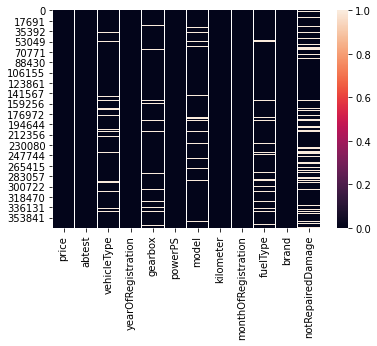

In [9]:
sns.heatmap(df.isnull());

In [10]:
values = {'vehicleType':'limousine', 'gearbox':'manuell', 'model':'golf',
          'fuelType':'benzin', 'notRepairedDamage':'nein'}
df.fillna(value=values, inplace=True)

In [11]:
df.isnull().sum()

price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64

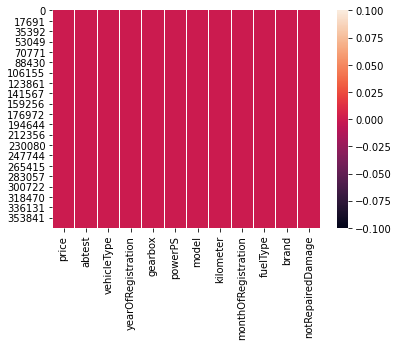

In [12]:
sns.heatmap(df.isnull());

In [13]:
X = df.iloc[:, 1:13].values
y = df.iloc[:, 0].values
X.shape, y.shape

((357061, 11), (357061,))

In [14]:
onehot = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(),
                                          [0,1,3,5,8,9,10])],
                                          remainder='passthrough')
X = onehot.fit_transform(X).toarray()
X.shape

(357061, 316)

In [15]:
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).view(-1,1)

## Etapa 3: Construção do modelo

In [16]:
class reg_torch(nn.Module):
  def __init__(self):
    super().__init__()
    self.dense0 = nn.Linear(316, 158)
    self.dense1 = nn.Linear(158, 158)
    self.dense2 = nn.Linear(158,1)
    self.activation = nn.ReLU()

  def forward(self, X):
    X = self.dense0(X)
    X = self.activation(X)
    X = self.dense1(X)
    X = self.activation(X)
    X = self.dense2(X)
    return X

In [17]:
reg_sklearn = NeuralNetRegressor(module=reg_torch, criterion=torch.nn.L1Loss,
                                 optimizer = torch.optim.Adam, max_epochs = 100,
                                 batch_size = 300, train_split = False)

## Etapa 4: Validação cruzada

In [18]:
results = cross_val_score(reg_sklearn, X, y, cv = 5,
                          scoring='neg_mean_absolute_error')

  epoch    train_loss     dur
-------  ------------  ------
      1     3576.1322  5.8642
      2     3037.6528  6.1828
      3     2856.2414  6.3235
      4     2816.9857  6.1914
      5     2801.6175  6.2790
      6     2865.6594  6.2791
      7     2718.9807  6.2664
      8     2668.5792  6.2667
      9     2630.2963  6.2649
     10     2607.4103  6.3319
     11     2567.8346  6.4140
     12     2554.0551  6.2387
     13     2542.3484  6.3096
     14     2529.5242  6.2521
     15     2492.8978  6.3274
     16     2495.6248  6.3969
     17     2499.7384  6.3538
     18     2471.4760  6.2732
     19     2477.1907  6.2932
     20     2471.2078  6.2185
     21     2449.8388  6.2500
     22     2451.7719  6.3355
     23     2438.5023  6.3031
     24     2435.4743  6.3162
     25     2434.3573  6.3394
     26     2431.7323  6.2519
     27     2436.8256  6.3466
     28     2418.0871  6.2891
     29     2424.7709  6.2035
     30     2433.0883  6.2598
     31     2398.6216  6.2566
     32   

In [19]:
mean = results.mean()
std = results.std()
mean, std

(-2366.344189453125, 65.78558320720043)

## Tarefa: Tuning params regressão carros usados

In [20]:
class reg_torch(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = nn.Linear(316, 158)
        torch.nn.init.uniform_(self.dense0.weight)
        self.dense1 = nn.Linear(158, 158)
        torch.nn.init.uniform_(self.dense1.weight)
        self.dense2 = nn.Linear(158, 1)
        
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, X):
        X = self.dense0(X)
        X = self.activation(X)
        X = self.dropout(X)
        X = self.dense1(X)
        X = self.activation(X)
        X = self.dropout(X)
        X = self.dense2(X)
        return X

In [21]:
reg_sklearn = NeuralNetRegressor(module = reg_torch, 
                                       optimizer = torch.optim.Adam,
                                       max_epochs = 100,
                                       batch_size = 300,
                                       train_split = False)

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
params = {'criterion': [torch.nn.MSELoss, torch.nn.L1Loss, torch.nn.SmoothL1Loss]}
grid_search = GridSearchCV(estimator = reg_sklearn,
                           param_grid = params, cv = 5)

In [24]:
grid_search = grid_search.fit(X, y)

  epoch         train_loss     dur
-------  -----------------  ------
      1  304792058478.0521  5.6587
      2  128796885.1972  5.9101
      3  93901180.6152  5.8705
      4  94566961.4555  5.7736
      5  96012593.4561  5.8335
      6  107638843.2127  5.7576
      7  274755927.7710  5.7326
      8  200061264.0827  5.7612
      9  135253881.9350  5.9208
     10  114250877.8578  5.8897
     11  103898888.4280  5.9116
     12  97516984.8888  5.9347
     13  79452826.4339  5.9549
     14  67388457.9553  6.0749
     15  63544222.3123  6.1645
     16  56522076.2288  6.1915
     17  51109451.0176  6.3022
     18  47871471.9428  6.4684
     19  43559182.8269  6.5041
     20  45374103.2160  6.4913
     21  42659826.4963  6.4267
     22  42592584.7014  6.3904
     23  43242326.2611  6.3187
     24  46035515.6915  6.4372
     25  43580035.4492  6.4226
     26  43638687.7666  6.4424
     27  43290498.8550  6.3648
     28  47556508.5774  6.3324
     29  49830986.7893  6.4390
     30  49242708.29

In [25]:
best_params = grid_search.best_params_
best_result = grid_search.best_score_
best_params, best_result

({'criterion': torch.nn.modules.loss.SmoothL1Loss}, 0.5178736679397501)